## Data loading

In [1]:
import pandas as pd
import torch
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [31]:
import pandas as pd
import pickle
import numpy as np
from fastai.collab import *
from pprint import pprint
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from operator import itemgetter

In [2]:
from urllib.request import urlopen
# the original csv from https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/
# The column ID is used in API calls to retrieve the game reviews
link="https://raw.githubusercontent.com/beefsack/bgg-ranking-historicals/master/2019-05-30.csv"
f = urlopen(link)
games = pd.read_csv(f)
games.describe()
games.sort_values('Users rated',ascending=False,inplace=True)
games.rename(index=str, columns={"Bayes average": "Geekscore",'Name':'name'}, inplace=True)

In [92]:
# load the file I composed with all the reviews

reviews = pd.read_csv('bgg-19m-reviews.csv', index_col=0)
print(len(reviews))
reviews.head()
reviews = reviews.sample(frac=0.002)

18964807


In [93]:
games_by_all_users = reviews.groupby('name')['rating'].agg(['mean','count']).sort_values('mean',ascending=False)
games_by_all_users['rank']=games_by_all_users.reset_index().index+1
print(len(games_by_all_users))
games_by_all_users.head()

7724


,mean,count,rank
name,,,
"Saipan: Conquest of the Marianas, June 1944",10.0,1,1
Monopoly: Nintendo Collector's Edition,10.0,1,2
Dark Ages: Heritage of Charlemagne,10.0,1,3
Lucky Forward: Patton's Third Army in Lorraine,10.0,1,4
Clue: The Haunted Mansion,10.0,1,5


## Collaborative Filtering using Fast.ai library

In [94]:
dls = CollabDataLoaders.from_df(reviews, bs=64, item_name='name', user_name='user', rating_name='rating', seed = 112)
dls.show_batch()

,user,name,rating
0,shilinski,Cleopatra and the Society of Architects,5.0
1,reddawg19,Waterloo Campaign 1815,6.0
2,jpatel02,Race for the Galaxy,10.0
3,HillKing,Vegas Showdown,7.0
4,jcmdoom,Tokaido,6.0
5,Brooster,Kingdomino,6.5
6,ChazIsidore,Diplomacy,5.0
7,tkanttila,Kingsport Festival,7.0
8,gosav,Dungeons & Dragons: The Legend of Drizzt Board Game,8.5
9,KatyAdams,Euphoria: Build a Better Dystopia,9.5


In [99]:
learn = collab_learner(dls, y_range=(1,10.5))


SuggestedLRs(valley=0.05754399299621582)

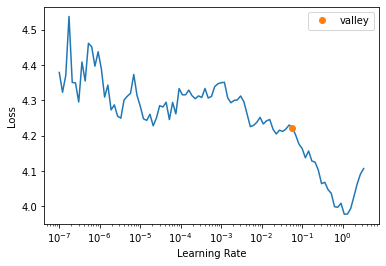

In [100]:
learn.lr_find()
# learn.recorder.plot()

In [102]:
learn.fit_one_cycle(5, lr_max=0.0531763744354248, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.562256,2.683156,00:02
1,2.529624,2.758448,00:02
2,2.314545,2.550054,00:03
3,1.769595,2.425257,00:03
4,1.179376,2.422596,00:03


In [71]:
learn.recorder.plot_losses()

AttributeError: 'EmbeddingDotBias' object has no attribute 'plot_losses'

In [72]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(255046, 50)
  (i_weight): Embedding(21356, 50)
  (u_bias): Embedding(255046, 1)
  (i_bias): Embedding(21356, 1)
)

In [73]:
g = reviews.groupby('name')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Carcassonne', 'Pandemic', 'Catan', '7 Wonders', 'Dominion',
       'Ticket to Ride', 'Codenames', 'Terraforming Mars',
       '7 Wonders Duel', 'Agricola'], dtype=object)

In [74]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [75]:
mean_ratings = reviews.groupby('name')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [76]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-1.3928), 'Chutes and Ladders', 2.825349397590361),
 (tensor(-1.1278), 'Candy Land', 3.0440618101545254),
 (tensor(-0.6474), 'Operation', 4.079349397590361),
 (tensor(-0.5453), 'Monopoly', 4.325537042614546),
 (tensor(-0.4668), 'The Game of Life', 4.314056088464874),
 (tensor(-0.4055), 'Battleship', 4.6715153723404255),
 (tensor(-0.4027), 'Sorry!', 4.497415730337078),
 (tensor(-0.3600), 'Twister', 4.506192893401016),
 (tensor(-0.3281), 'Pachisi', 4.461059602649007),
 (tensor(-0.3269), 'Guess Who?', 4.735505617977529),
 (tensor(-0.2325), 'Trivial Pursuit: Genus Edition', 4.993042944785276),
 (tensor(-0.2292), 'Connect Four', 4.87081718367347),
 (tensor(-0.2066), 'Chinese Checkers', 5.142302483069978),
 (tensor(-0.1707), 'Checkers', 4.881630847029077),
 (tensor(-0.1345), 'Pass the Pigs', 5.2587711558669)]

In [77]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(1.9241), 'Twilight Imperium: Fourth Edition', 8.642056885245902),
 (tensor(1.8787), 'Kingdom Death: Monster', 8.576780821917808),
 (tensor(1.8654), 'Gloomhaven', 8.792158811612364),
 (tensor(1.8423),
  'Clank!: Legacy – Acquisitions Incorporated',
  8.673530303030303),
 (tensor(1.8366), 'Eclipse: Second Dawn for the Galaxy', 8.682764221388368),
 (tensor(1.8107), 'Brass: Birmingham', 8.642893493230174),
 (tensor(1.7708), 'Gloomhaven: Jaws of the Lion', 8.686771497261107),
 (tensor(1.7362), 'Pandemic Legacy: Season 1', 8.6008892154767),
 (tensor(1.6863), 'War of the Ring: Second Edition', 8.506022369127518),
 (tensor(1.6226), 'Nemesis', 8.406019924160347),
 (tensor(1.6177), 'Too Many Bones', 8.419599124183007),
 (tensor(1.5931), 'Gaia Project', 8.450149134221311),
 (tensor(1.5837), 'Star Wars: Rebellion', 8.457270405092594),
 (tensor(1.5655),
  'Through the Ages: A New Story of Civilization',
  8.415795857030016),
 (tensor(1.5510), 'Tainted Grail: The Fall of Avalon', 8.36913114

In [78]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [79]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [80]:
fac0,fac1,fac2 = movie_pca.t()
# first dimension
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [81]:

sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8630), 'Carcassonne Junior'),
 (tensor(0.7367), 'Combat Commander: Europe'),
 (tensor(0.7085), 'The Castles of Burgundy: The Card Game'),
 (tensor(0.6986), 'Shadows of Brimstone: City of the Ancients'),
 (tensor(0.6601), 'Barrage'),
 (tensor(0.6395), 'Pass the Pigs'),
 (tensor(0.6185), 'Timeline: General Interest'),
 (tensor(0.6127), 'Axis & Allies'),
 (tensor(0.6008), 'Terraforming Mars: Ares Expedition'),
 (tensor(0.5773), 'Tide of Iron')]

In [82]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0086), 'When I Dream'),
 (tensor(-0.8968), 'Clank!: Legacy – Acquisitions Incorporated'),
 (tensor(-0.7987), 'Nemesis'),
 (tensor(-0.7166), 'Battle Sheep'),
 (tensor(-0.6260), 'Middle-Earth Quest'),
 (tensor(-0.6259), 'Samurai Sword'),
 (tensor(-0.6002), 'Twilight Imperium: Third Edition'),
 (tensor(-0.5968), 'Medieval Academy'),
 (tensor(-0.5790), 'Under Falling Skies'),
 (tensor(-0.5739), 'World of Warcraft: The Boardgame')]

In [83]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.5784), 'A Game of Thrones: The Card Game (Second Edition)'),
 (tensor(0.7502), 'Star Wars: Outer Rim'),
 (tensor(0.7247), 'Onirim'),
 (tensor(0.6440), 'Lords of Hellas'),
 (tensor(0.6298), 'Clank!: Legacy – Acquisitions Incorporated'),
 (tensor(0.6275), 'Argent: The Consortium'),
 (tensor(0.6073), 'Evolution: Climate'),
 (tensor(0.5854), 'Too Many Bones'),
 (tensor(0.5697), 'The Downfall of Pompeii'),
 (tensor(0.5550), 'Mahjong')]

In [84]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.7801), 'Altiplano'),
 (tensor(-0.7628), 'Tainted Grail: The Fall of Avalon'),
 (tensor(-0.7188), 'Guess Who?'),
 (tensor(-0.6791), 'Bausack'),
 (tensor(-0.6579), 'Dungeons & Dragons: The Legend of Drizzt Board Game'),
 (tensor(-0.6472), 'Tiny Epic Western'),
 (tensor(-0.6448), 'Unstable Unicorns'),
 (tensor(-0.6414), 'Arkham Horror (Third Edition)'),
 (tensor(-0.6399), 'Marvel Dice Masters: Avengers vs. X-Men'),
 (tensor(-0.6232), 'Munchkin Quest')]

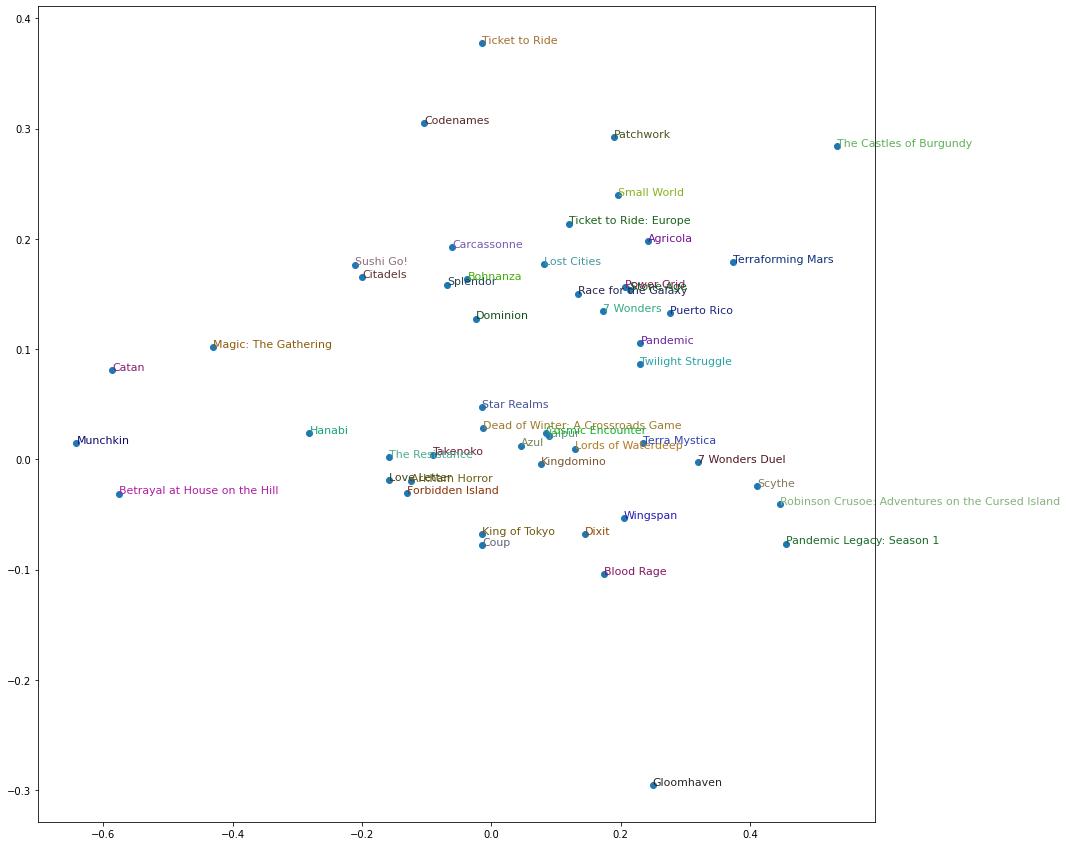

In [58]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [9]:
data = CollabDataBunch.from_df(reviews, user_name='user',item_name='name',rating_name='rating',bs=100000, seed = 42)
data.show_batch()

NameError: name 'CollabDataBunch' is not defined

In [7]:
learner = collab_learner(data, n_factors=50, y_range=(2.,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


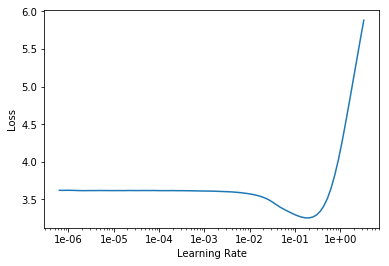

In [32]:
lr_find(learner)
learner.recorder.plot()

In [33]:
learner.fit_one_cycle(3, 1e-2, wd=0.15)

epoch,train_loss,valid_loss,time
0,2.198961,1.654890,02:14
1,1.526543,1.486123,02:14
2,1.214744,1.469154,02:12


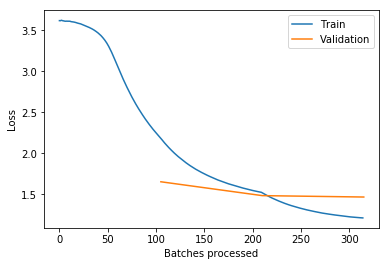

In [36]:
learner.recorder.plot_losses()

In [8]:
#learner.save('3cycles1e-2-bs100000factors50yrange2-10wd005')
#learner.load('3cycles1e-2-bs100000factors50yrange2-10wd005')
learner.model

EmbeddingDotBias(
  (u_weight): Embedding(277642, 50)
  (i_weight): Embedding(16693, 50)
  (u_bias): Embedding(277642, 1)
  (i_bias): Embedding(16693, 1)
)

In [17]:
CUTOFF = 5000
mean_ratings = reviews.groupby('name')['rating'].mean()
top_games = games_by_all_users[games_by_all_users['count']>CUTOFF].sort_values('mean',ascending=False).index
print(len(top_games))
game_bias = learner.bias(top_games, is_item=True)
game_bias.shapemean_ratings = reviews.groupby('name')['rating'].mean()
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]
item0 = lambda o:o[0]

531


In [18]:
sorted(game_ratings, key=item0)[:10]

[(tensor(-0.3486), 'Monopoly', 4.380775175920025),
 (tensor(-0.3193), 'Battleship', 4.595128421199444),
 (tensor(-0.3119), 'The Game of Life', 4.23011018775603),
 (tensor(-0.2821), 'Checkers', 4.8557299132711504),
 (tensor(-0.2301),
  'Killer Bunnies and the Quest for the Magic Carrot',
  5.4962755463798745),
 (tensor(-0.2273), 'Connect Four', 4.849008524240809),
 (tensor(-0.2195), 'Phase 10', 5.088487233665916),
 (tensor(-0.1989), 'Yahtzee', 5.320197324357157),
 (tensor(-0.1633), 'UNO', 5.360617500297866),
 (tensor(-0.1605), 'Risk', 5.581480525773593)]

In [19]:
sorted(game_ratings, key=lambda o: o[0], reverse=True)[:25]

[(tensor(0.4665), 'Kingdom Death: Monster', 8.80980120344829),
 (tensor(0.3844), 'Twilight Imperium (Fourth Edition)', 8.729413089670137),
 (tensor(0.3833), 'Gloomhaven', 8.903553648356118),
 (tensor(0.3318), 'Terraforming Mars', 8.400691480172773),
 (tensor(0.3277), 'HeroQuest', 7.101169318299367),
 (tensor(0.3276), 'Arkham Horror: The Card Game', 8.22251270943396),
 (tensor(0.3271), 'Brass: Birmingham', 8.61948408928907),
 (tensor(0.3270), 'Pandemic Legacy: Season 1', 8.642492341401908),
 (tensor(0.3233), 'Dune', 7.525325597715967),
 (tensor(0.3223), 'Civilization', 7.517448234944239),
 (tensor(0.3210), 'The 7th Continent', 8.424031104308396),
 (tensor(0.3201), 'Star Wars: Rebellion', 8.445849852405225),
 (tensor(0.3187), 'Spirit Island', 8.372263601936222),
 (tensor(0.3162), 'Hero Realms', 7.694196930315378),
 (tensor(0.3157), 'Wingspan', 8.20744788191191),
 (tensor(0.3148), 'Go', 7.646139150049287),
 (tensor(0.3120), 'War of the Ring (Second Edition)', 8.426209182667625),
 (tensor(

In [20]:
game_weights = learner.weight(top_games, is_item=True)
game_weights.shape

torch.Size([531, 50])

In [21]:
game_pca = game_weights.pca(3)
game_pca.shape

torch.Size([531, 3])

In [22]:
fac0,fac1,fac2 = game_pca.t()
game_comp = [(f, i) for f,i in zip(fac0, top_games)]
pprint(sorted(game_comp, key=itemgetter(0), reverse=True)[:10]) # pretty friendly worker placement games
pprint(sorted(game_comp, key=itemgetter(0), reverse=False)[:10]) # horror/zombie games?

[(tensor(2.0150), 'Monopoly'),
 (tensor(1.9891), 'The Game of Life'),
 (tensor(1.5296), 'Phase 10'),
 (tensor(1.3959), 'Zombies!!!'),
 (tensor(1.3664), 'Battleship'),
 (tensor(1.2959), 'Fluxx'),
 (tensor(1.2379), 'UNO'),
 (tensor(1.2315), 'Apples to Apples'),
 (tensor(1.2242), 'Cards Against Humanity'),
 (tensor(1.2237), 'Zombie Fluxx')]
[(tensor(-2.2865), 'Gloomhaven'),
 (tensor(-2.1583), 'Gaia Project'),
 (tensor(-2.0837), 'Brass: Birmingham'),
 (tensor(-1.9872), 'Through the Ages: A New Story of Civilization'),
 (tensor(-1.8044), 'Twilight Imperium (Fourth Edition)'),
 (tensor(-1.7466), 'Great Western Trail'),
 (tensor(-1.6795), 'Terra Mystica'),
 (tensor(-1.6405), 'Spirit Island'),
 (tensor(-1.6355), 'Terraforming Mars'),
 (tensor(-1.5805), 'Food Chain Magnate')]


In [23]:
#fantasy versus real world/abstract
game_comp = [(f, i) for f,i in zip(fac1, top_games)]
pprint(sorted(game_comp, key=itemgetter(0), reverse=True)[:10])
pprint(sorted(game_comp, key=itemgetter(0), reverse=False)[:10])

[(tensor(1.2400), 'Puerto Rico'),
 (tensor(1.0963), 'Caylus'),
 (tensor(1.0638), 'Agricola'),
 (tensor(1.0551), 'Tigris & Euphrates'),
 (tensor(1.0411), 'The Princes of Florence'),
 (tensor(1.0147), 'Hansa Teutonica'),
 (tensor(0.9834), 'Go'),
 (tensor(0.9344), 'El Grande'),
 (tensor(0.9306), 'The Castles of Burgundy'),
 (tensor(0.9154), 'Goa')]
[(tensor(-1.6890), 'Eldritch Horror'),
 (tensor(-1.5237), 'Kingdom Death: Monster'),
 (tensor(-1.5056), 'Mansions of Madness: Second Edition'),
 (tensor(-1.4176), 'Star Wars: Imperial Assault'),
 (tensor(-1.4133), 'Dead of Winter: A Crossroads Game'),
 (tensor(-1.3214), 'Arkham Horror'),
 (tensor(-1.3146), 'T.I.M.E Stories'),
 (tensor(-1.3013), 'Zombicide: Black Plague'),
 (tensor(-1.2878), 'Arkham Horror: The Card Game'),
 (tensor(-1.2802), 'Dead of Winter: The Long Night')]


In [24]:
#this one i don't get
game_comp = [(f, i) for f,i in zip(fac2, top_games)]
pprint(sorted(game_comp, key=itemgetter(0), reverse=True)[:10])
pprint(sorted(game_comp, key=itemgetter(0), reverse=False)[:10])

[(tensor(1.1475), 'Wingspan'),
 (tensor(1.0679), 'Sagrada'),
 (tensor(1.0493), 'Viticulture Essential Edition'),
 (tensor(1.0356), 'Century: Spice Road'),
 (tensor(1.0276), 'Azul'),
 (tensor(0.9598), 'Pandemic Legacy: Season 1'),
 (tensor(0.9532), 'Sushi Go Party!'),
 (tensor(0.9322), 'Kingdomino'),
 (tensor(0.9225), 'Raiders of the North Sea'),
 (tensor(0.8969), 'Bärenpark')]
[(tensor(-1.6859), 'Go'),
 (tensor(-1.5073), 'Diplomacy'),
 (tensor(-1.4322), 'Android: Netrunner'),
 (tensor(-1.4176), 'Through the Ages: A Story of Civilization'),
 (tensor(-1.3819), 'Twilight Struggle'),
 (tensor(-1.3304), 'Age of Steam'),
 (tensor(-1.3120), 'Chess'),
 (tensor(-1.2489), 'A Game of Thrones: The Board Game (Second Edition)'),
 (tensor(-1.2432), 'A Game of Thrones (First Edition)'),
 (tensor(-1.1923), 'A Game of Thrones: The Card Game')]


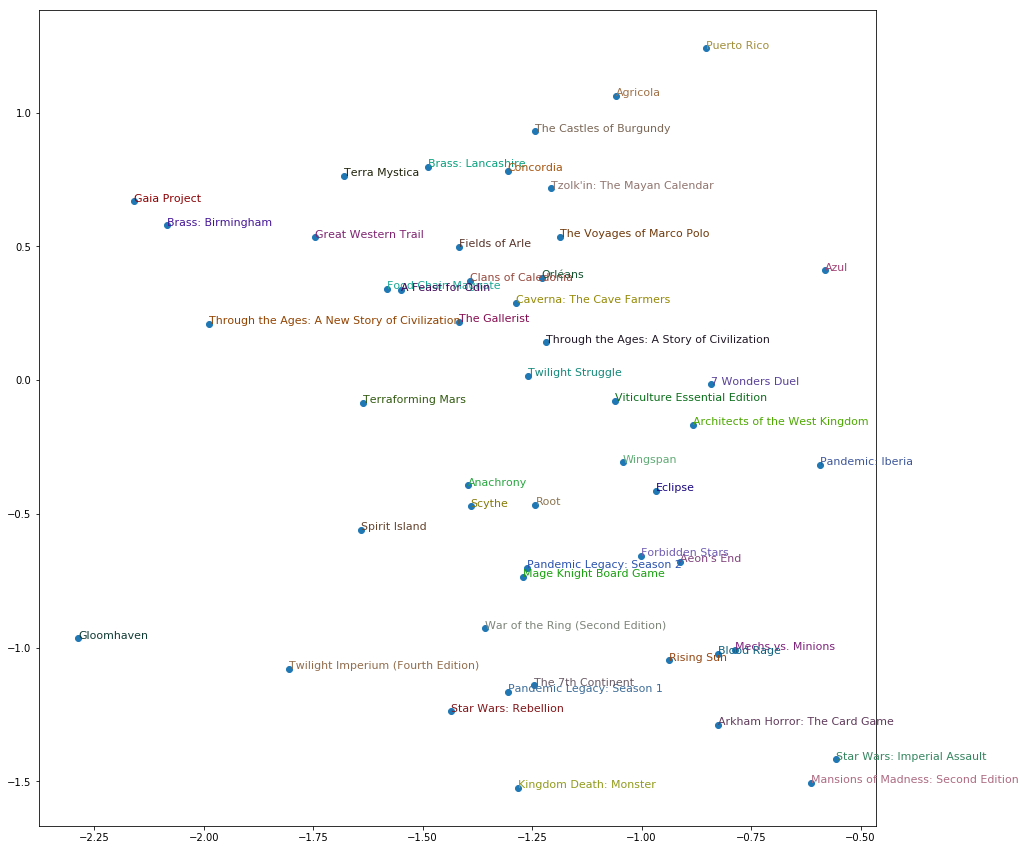

In [25]:
idxs = np.random.choice(len(top_games), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_games[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# Find similar games

In [26]:
top_games = games_by_all_users[games_by_all_users['count']>500].sort_values('mean',ascending=False).index
print(len(top_games))
game_bias = learner.bias(top_games, is_item=True)
game_bias.shapemean_ratings = reviews.groupby('name')['rating'].mean()
game_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_games,game_bias)]
item0 = lambda o:o[0]
sorted(game_ratings, key=lambda o: o[0], reverse=True)[:25]

3470


[(tensor(0.5076), 'Escape the Dark Castle', 8.114045689655175),
 (tensor(0.4665), 'Kingdom Death: Monster', 8.80980120344829),
 (tensor(0.3965), 'Deep Madness', 8.205578358531318),
 (tensor(0.3856),
  'Unconditional Surrender! World War 2 in Europe',
  8.402274881516588),
 (tensor(0.3844), 'Twilight Imperium (Fourth Edition)', 8.729413089670137),
 (tensor(0.3833), 'Gloomhaven', 8.903553648356118),
 (tensor(0.3770), 'Plague Inc.: The Board Game', 7.643024487935649),
 (tensor(0.3728), 'Endeavor: Age of Sail', 8.192791212313546),
 (tensor(0.3706), 'Mega Civilization', 8.277965144230768),
 (tensor(0.3673), 'Star Trek: Attack Wing', 7.53076305220883),
 (tensor(0.3656), 'Frostgrave', 8.084085657370519),
 (tensor(0.3613), 'Triumph & Tragedy', 8.238693089430893),
 (tensor(0.3601), 'Nemesis', 8.48634888519924),
 (tensor(0.3593), 'Mythic Battles: Pantheon', 8.620900529509097),
 (tensor(0.3520), 'Eat Poop You Cat', 7.49661930294906),
 (tensor(0.3518), 'Strat-O-Matic Baseball', 7.6902406),
 (tenso

In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
import pickle
with open('games_by_all_users.pickle', 'wb') as handle:
    pickle.dump(games_by_all_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
top_games = games_by_all_users[games_by_all_users['count']>1000].sort_values('mean',ascending=False).reset_index()
game_weights = learner.weight(top_games['name'], is_item=True)
game_bias = learner.bias(top_games['name'], is_item=True)
npweights = game_weights.numpy()
top_games['model_score']=game_bias.numpy()
top_games['weights_sum']=np.sum(np.abs(npweights),axis=1)

nn = NearestNeighbors(n_neighbors=10)
fitnn = nn.fit(npweights)

In [30]:
distances,indices = fitnn.kneighbors([npweights[1223]])

In [31]:
res = top_games[top_games['name'].str.contains('Coconuts')]
if len(res)==1:
    distances,indices = fitnn.kneighbors([npweights[res.index[0]]])
else:
    print(res.head())

In [32]:
top_games.iloc[indices[0][:500]].sort_values('model_score',ascending=False)

,name,mean,count,rank,model_score,weights_sum
762,Tumblin-Dice,7.177753,3460,2995,0.257285,8.450797
894,Coconuts,7.070444,3062,3562,0.255847,7.856468
989,Loony Quest,7.012931,4306,3907,0.199111,7.158642
1058,Rhino Hero,6.964009,6307,4176,0.183292,7.482912
1223,Animal Upon Animal,6.850299,5938,4911,0.183022,7.121556
1308,Ghost Blitz 2,6.784539,1322,5376,0.165168,7.648420
1380,Ghost Blitz,6.731855,5424,5766,0.147967,7.923955
1427,Dr. Eureka,6.697367,2363,6006,0.138598,6.470623
1318,Say Anything,6.781342,5122,5403,0.107839,8.259356
1717,Click Clack Lumberjack,6.452125,3191,7862,0.087289,8.210957


In [33]:
for d in distances[0]: print(d)

0.0
0.9034415689269378
0.9059429138692521
0.9471267382319517
0.9647173242209175
0.9684741733495199
0.9753135981358055
0.9809447296767007
0.982072494185953
0.9842351197950258


In [34]:
top_games.sort_values('weights_sum',ascending=False)[:100]

,name,mean,count,rank,model_score,weights_sum
2137,Tic-Tac-Toe,2.608882,2769,16678,-0.381589,24.849243
2136,War,2.616306,1305,16677,-0.385485,23.859728
2134,Chutes and Ladders,2.820847,3125,16668,-0.399438,22.818176
2135,Bingo,2.762277,1799,16673,-0.380525,22.345882
2132,LCR,3.261187,1523,16657,-0.362845,21.802368
0,Gloomhaven,8.903554,24485,35,0.383276,20.741590
2133,Candy Land,3.172635,3408,16661,-0.373037,19.993757
1,Kingdom Death: Monster,8.809801,5800,44,0.466535,19.462381
2,Twilight Imperium (Fourth Edition),8.729413,6457,53,0.384380,19.369850
3,Pandemic Legacy: Season 1,8.642492,30943,68,0.326969,19.288017
